MAE = 1.014468e+63 °C
MSE = 4.972509e+123 °C^2


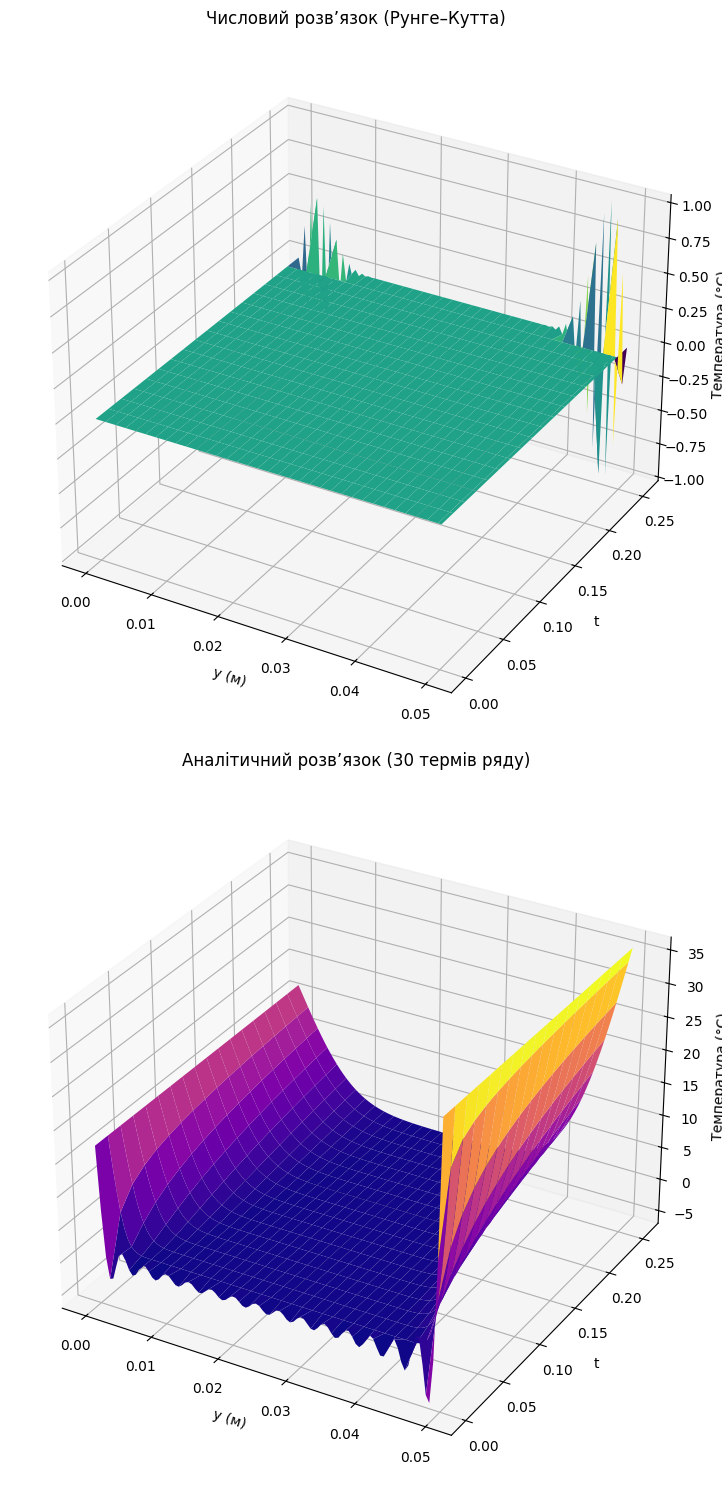

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad

a = 84.18e-6      # [м²/с] Коеф. температуропровідності
L = 0.05          # [м]    Товщина стінки
T = 0.25          # [c]    Час моделювання
N = 100           # Кількість сегментів за простором (N+1 вузлів)
dt = 0.015        # Крок інтегрування за часом
alpha = 17.0      # [°C]   Температура на лівій межі (y=0)
beta = 36.0       # [°C]   Температура на правій межі (y=L)
initial_temp = 0.0 # [°C]  Початкова температура в стінці


# 1) ЧИСЕЛЬНЕ РОЗВ’ЯЗАННЯ МЕТОДОМ РУНГЕ–КУТТА 4-ГО ПОРЯДКУ


dy = L / N
y_points = np.linspace(0, L, N+1)


time_points = np.arange(0, T + dt, dt)
M = len(time_points)  # кількість кроків часу


u_num = np.zeros((M, N+1)) # Температура в момент часу k*dt у точці i*dy


u_num[:, 0]  = alpha  # при y=0
u_num[:, -1] = beta   # при y=L

# Початковий розподіл (внутрішні вузли)
u_num[0, 1:-1] = initial_temp

def dudt(u_vec):

    res = np.zeros_like(u_vec)
    for i in range(1, len(u_vec)-1):
        res[i] = a * (u_vec[i+1] - 2*u_vec[i] + u_vec[i-1]) / (dy**2)
    return res

# Класичний метод Рунге–Кутта (4-го порядку) для кожного кроку часу
for k in range(M - 1):
    u_current = u_num[k, :].copy()
    k1 = dudt(u_current)
    k2 = dudt(u_current + 0.5*dt*k1)
    k3 = dudt(u_current + 0.5*dt*k2)
    k4 = dudt(u_current + dt*k3)


    u_next = u_current + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    u_next[0]  = alpha
    u_next[-1] = beta

    u_num[k+1, :] = u_next

# 2) АНАЛІТИЧНИЙ РОЗВ’ЯЗОК ЧЕРЕЗ ЧАСТКОВУ СУМУ РЯДУ

def A_n(n, L, alpha, beta):

  #  Коефіцієнт ряду Фур'є для w(0,y) = -[alpha + (beta-alpha)*y/L].
   # A_n = (2/L) * інтеграл_0^L [ w(0,y) * sin(pi*n*y/L ) ] dy.

    def f0(y):
        return - alpha - (beta - alpha)*(y/L)  # початковий відхил від стаціонару
    integrand = lambda y: f0(y)*np.sin(np.pi*n*y/L)
    val, _ = quad(integrand, 0, L)
    return (2.0 / L) * val


N_terms = 30
A_vals = np.array([A_n(n, L, alpha, beta) for n in range(1, N_terms+1)])

def u_analytic(t, y, a, L, alpha, beta, A_vals):

   # Аналітичний розв’язок:
    #  u(t,y) = U_ss(y) + sum_{n=1..N_terms} [ A_n * exp(-(pi*n/L)^2 * a * t) * sin(pi*n*y/L) ]

    U_ss = alpha + (beta - alpha)*(y/L)
    w_sum = 0.0
    for n in range(1, N_terms+1):
        An = A_vals[n-1]
        w_sum += An * np.exp(- (np.pi*n/L)**2 * a * t) * np.sin(np.pi*n*y/L)
    return U_ss + w_sum

#  2D-масив для аналітичного розв’язку
u_ana = np.zeros((M, N+1))
for k in range(M):
    t_k = time_points[k]
    for i in range(N+1):
        y_i = y_points[i]
        u_ana[k, i] = u_analytic(t_k, y_i, a, L, alpha, beta, A_vals)

# 3) MAE, MSE

diff = u_num - u_ana
MAE = np.max(np.abs(diff))
MSE = np.mean(diff**2)

print(f"MAE = {MAE:.6e} °C")
print(f"MSE = {MSE:.6e} °C^2")


# 4) ПОБУДОВА 3D-ГРАФІКІВ
fig = plt.figure(figsize=(10, 15))

# Для числового розв'язку
ax1 = fig.add_subplot(2, 1, 1, projection='3d')
Y, T_grid = np.meshgrid(y_points, time_points)
surf1 = ax1.plot_surface(Y, T_grid, u_num, cmap='viridis')
ax1.set_title("Числовий розв’язок (Рунге–Кутта)", pad=15)
ax1.set_xlabel("y (м)")
ax1.set_ylabel("t")
ax1.set_zlabel("Температура (°C)")

# Для аналітичного розв'язку
ax2 = fig.add_subplot(2, 1, 2, projection='3d')
surf2 = ax2.plot_surface(Y, T_grid, u_ana, cmap='plasma')
ax2.set_title("Аналітичний розв’язок (30 термів ряду)", pad= 15)
ax2.set_xlabel("y (м)")
ax2.set_ylabel("t")
ax2.set_zlabel("Температура (°C)")

plt.tight_layout()
plt.show()
